```{image} ../images/ipcc.jpg
:width: 100%
:align: center
```

# Cambio Climático: Ensamble multimodelo

---

## Introducción
En este cuadernillo (Notebook) aprenderemos:

1. Breve introducción a los escenarios de Cambio Climático.
1. Proyecto de inter-comparación de modelos de clima acoplados - CMIP.
1. Acceso a los datos CMIP6 en formato Zarr.
1. Reproduccion de la gráfica de la Temperatura Media Global de la Superficie del Mar - CMIP6.

## 📚 Descripción general

En este cuaderno aprenderás a trabajar con proyecciones de cambio climático del Proyecto de Intercomparación de Modelos Acoplados fase 6 (CMIP6), utilizando datos de temperatura superficial del mar de múltiples modelos climáticos bajo diferentes escenarios de emisiones.

Explorarás cómo acceder a grandes volúmenes de datos climáticos almacenados en formato Zarr en Google Cloud mediante catálogos Intake-ESM. Aplicarás técnicas de ponderación espacial para calcular promedios globales correctos, y aprenderás a construir ensambles multimodelo que combinan proyecciones de diferentes centros de modelación para evaluar la incertidumbre en las proyecciones futuras del clima.

## ✅ Requisitos previos

| Conceptos | Importancia | Notas |
| --- | --- | --- |
| [Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necesario |  Manejo de datos multidimensionales espacializados|
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necesario |  Generación de gráficas|
| [CMIP6](https://projectpythia.org/cmip6-cookbook/README.html#) | Necesario |  Ejemplos y análisis de CMIP6|
| [NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Útil | Familiaridad con la estructura de datos y metadatos. |
| [Intake](https://projectpythia.org/intake-cookbook/README.html) | Útil | Cátalogo que nos permite acceder a datos de diversas fuentes |


⏱️ **Tiempo estimado de aprendizaje**: 30 minutos

✍️ **Formato**: Interactivo

---

## Librerías

Importamos las librerías que usaremos a lo largo de este cuadernillo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pandas import date_range
from xarrayutils.plotting import shaded_line_plot
from xmip.postprocessing import concat_members, match_metrics
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xarray import DataTree

xr.set_options(keep_attrs=True)
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

## 1. Introduccion a los escenarios de Cambio Climático

Los escenarios de cambio climático son una serie de modelos que se han desarrollado con el fin de comprender nuestro clima y las implicaciones futuras de las continuas emisiones de gases de efecto invernadero en la atmósfera. Estos esfuerzos se han concentrado en el Proyecto de Intercomparacion de Modelos (MIP) que invita a entidades de diferentes partes del mundo a realizar simulaciones utilizando modelos bajo escenarios de forzamiento radiativo centralizado (Abernathey, R. 2021). El más reciente Proyecto de Intercomparación de Modelos Acoplados fase 6 ([CMIP6](https://gmd.copernicus.org/articles/9/1937/2016/)) representa un esfuerzo internacional para enfocar el conocimiento acerca de la posible evolucion del sistema climático futuro, y que se encuentra consignado y resumido en el [Informe del Panel Intergubernamental sobre el Cambio Climático](https://github.com/IPCC-WG1/Chapter-9).

```{admonition} 📽️ Recurso adicional: Presentación sobre Cambio Climático
:class: tip

Para una mejor comprensión de los escenarios de cambio climático y la modelación climática, consulta esta presentación de [Climate Match Academy](https://comptools.climatematch.io/tutorials/intro.html) (CC BY 4.0):

**[Ver/Descargar presentación](https://osf.io/y2bdn/)**

La presentación cubre conceptos fundamentales sobre el cambio climático y la modelación del sistema climático.
```

## 2. Acceso a los datos CMIP6

Los datos de los diferentes modelos se encuentran disponibles en la plataforma en la nube de `Google Storage` en formato [`Zarr`](https://zarr.readthedocs.io/en/stable/). Para acceder a los datos de los diferentes escenarios de cambio climático podemos usar la librería [`xmip`](https://cmip6-preprocessing.readthedocs.io/en/latest/?badge=latest). Para crear una conexión con el repositorio de datos de Google usaremos el método [`google_cmip_col`](https://cmip6-preprocessing.readthedocs.io/en/latest/_modules/xmip/utils.html) que nos permite acceder a los datos de [`Pangeo`](https://pangeo.io/) a través de [`intake`](https://intake.readthedocs.io/en/latest/) de la siguiente manera:

In [3]:
cat = google_cmip_col()
cat

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,61


Como podemos ver hay una gran cantidad de modelaciones de más de 30 instituciones alrededor del mundo. Para efectos pedagógicos, vamos a hacer una consulta de los modelos [IPSL](https://cmc.ipsl.fr/ipsl-climate-models/), [MPI](https://gmd.copernicus.org/articles/12/3241/2019/), [GFDL](https://www.gfdl.noaa.gov/research_highlight/the-gfdl-earth-system-model-version-4-1-gfdl-esm4-1-model-description-and-simulation-characteristics/), [EC](https://ec-earth.org/), [CMCC](https://www.cmcc.it/models/cmcc-esm-earth-system-model) y [CESM2](https://www.cesm.ucar.edu/models/cesm2) para el periodo **histórico** y cada uno de los de los **escenarios (SSP - Shared Socioeconomic Pathways) proyectados** (`ssp126`, `ssp245`, `ssp370`, `ssp585`). 

Debemos crear un diccionario que nos permita posteriormente filtrar los datos deseados de la siguiente manera:

In [4]:
query = dict(
    source_id=[
        "IPSL-CM6A-LR",
        "MPI-ESM1-2-LR",
        # "GFDL-ESM4",
        # "EC-Earth3",
        "CMCC-ESM2",
        # "CESM2",
    ],
    experiment_id=["historical", "ssp126", "ssp370", "ssp245", "ssp585"],
    grid_label="gn",
)

El parámetro de etiqueta de retícula [`grid_label`](https://github.com/WCRP-CMIP/CMIP6_CVs/blob/master/CMIP6_grid_label.json) hace referencia a si los datos son reportados en retícula original (`gn`) o fue reprocesado a una nueva retícula (`gr`) en formato `lat` y `lon`.

Para filtrar los datos podemos aplicar el método `.search` a nuestro catálogo. Le pasamos los filtros previamente definidos incluyendo el identificador de la [variable](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y) (`variable_id`), para nuestro caso la temperatura superficial del mar `tos`. Pasamos también el identificador de miembro `member_id` que para nuestro caso es `r1i1p1f1`.  

La etiqueta de miembro nos indica lo siguiente:
*  r = realización
*  i = inicialización
*  p = física (parametrización)
*  f = forzamiento radiativo

 Como último parámetro en nuestro ejemplo pasamos el identificador de table `table_id` que para nuestro caso son datos mensuales del oceano `Omon`.

In [5]:
cat_filt = cat.search(
    **query,
    variable_id="tos",
    member_id=[
        "r1i1p1f1",
    ],  #'r2i1p1f1'
    table_id="Omon",
)
cat_filt

,unique
activity_id,2
institution_id,3
source_id,3
experiment_id,5
member_id,1
table_id,1
variable_id,1
grid_label,1
zstore,15
dcpp_init_year,1


`Intake` nos permite acceder a los datos de manera rápida y fácil usando `Xarray`. Para cargar estos datos en un `Dataset` podemos aplicarle el método `.to_dataset_dict` que nos permite crear un `diccionario` con todos los modelos. Podemos pasar un diccionario `kwargs` con argumentos que nos permiten realizar preprocesamiento de los datos como: renombrar algunos archivos, corregir coordenadas, unidades, entre otros (como podemos ver [acá](https://github.com/jbusecke/xMIP/blob/ec4006a7335ca00fd988cf03ac7121f046610f8a/xmip/preprocessing.py)). 

In [6]:
kwargs = dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs=dict(use_cftime=True),
    aggregate=False,
)
ddict = cat_filt.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [7]:
print(list(ddict.keys())[:2])

['ScenarioMIP.CMCC.CMCC-ESM2.ssp370.r1i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ssp370/r1i1p1f1/Omon/tos/gn/v20210202/.20210202', 'ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp245.r1i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp245/r1i1p1f1/Omon/tos/gn/v20190119/.20190119']


Revisemos el contenido de uno de estos archivos

In [8]:
ds_test = ddict[
    "ScenarioMIP.CMCC.CMCC-ESM2.ssp126.r1i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ssp126/r1i1p1f1/Omon/tos/gn/v20210126/.20210126"
]
display(ds_test)

<xarray.Dataset> Size: 448MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1032, x: 292,
                     y: 362, vertex: 4, bnds: 2)
Coordinates:
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) object 8B None
  * time            (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:0...
  * x               (x) int64 2kB 0 1 2 3 4 5 6 ... 285 286 287 288 289 290 291
  * y               (y) int64 3kB 0 1 2 3 4 5 6 ... 355 356 357 358 359 360 361
    lat             (x, y) float64 846kB dask.array<chunksize=(292, 362), meta=np.ndarray>
    lon             (x, y) float64 846kB dask.array<chunksize=(292, 362), meta=np.ndarray>
    lat_verticies   (x, y, vertex) float64 3MB dask.array<chunksize=(292, 362, 4), meta=np.ndarray>
    lon_verticies   (x, y, vertex) float64 3MB dask.array<chunksize=(292, 362, 4), meta=np.ndarray>
    time_bounds     (time, bnds) object 17kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
    lon_bounds      (bnds, x, y) float64 2MB dask.array<chunksize=(1, 292, 362), meta=np.ndarray>
    lat_bounds      (bnds, x, y) float64 2MB dask.array<chunksize=(1, 292, 362), meta=np.ndarray>
Dimensions without coordinates: vertex, bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, x, y) float32 436MB dask.array<chunksize=(1, 1, 253, 292, 362), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             60225.0
    branch_time_in_parent:            60225.0
    cmor_version:                     3.6.0
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-...
    intake_esm_attrs:version:         20210126
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.CMCC.CMCC-ESM2.ssp126.r1i1p...

Ahora una inspección gráfica

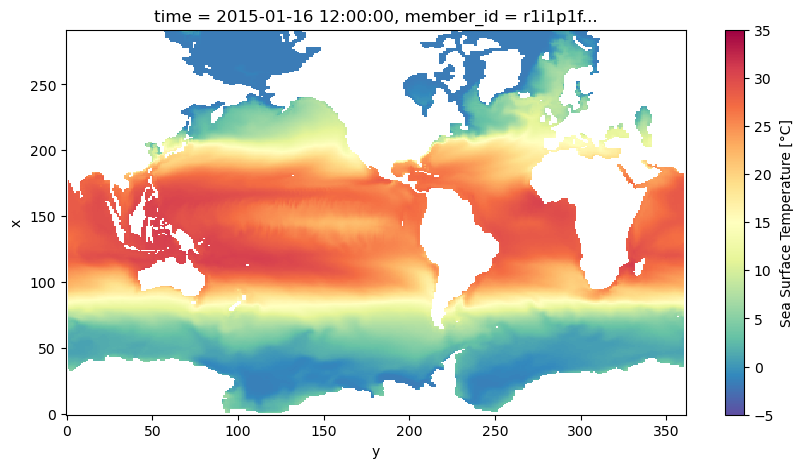

In [9]:
ds_test.isel(member_id=0, dcpp_init_year=0, time=0).tos.plot(
    cmap="Spectral_r", vmin=-5, vmax=35
);

## 3. Temperatura media global ponderada

La temperatura superficial del mar, y cualquier otra variable o salida de los modelos de cambio climático, debe ser ponderada por el **área** de cada celda. 

<img src="../images/cubed_sphere.jpeg" width=400 alt="IPCC"></img>

Créditos: [Gael Forget](https://gaelforget.net/). Para mas información acerca de las simulaciones y las retículas ver [https://doi.org/10.5194/gmd-8-3071-2015](https://gmd.copernicus.org/articles/8/3071/2015/)

Estas áreas ya estan calculadas y disponibles para su consulta de manera similar a los datos de `temperatura`. Hagamos una consulta al catálogo similar a la anterior cambiando los campos de `variable_id=areacello` y `table_id=Ofx`. 

In [10]:
cat_area = cat.search(
    **query,
    table_id="Ofx",
    variable_id="areacello",
)
ddict_area = cat_area.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


para realizar el cálculo de la temperatura media ponderada por latitud podemos utilizar el módulo [`match_metrics`](https://cmip6-preprocessing.readthedocs.io/en/latest/_modules/xmip/postprocessing.html) de la libreria `xmip` de python de la siguiente manera:

In [11]:
ddict_w_area = match_metrics(ddict, ddict_area, "areacello", print_statistics=True)

Processed 15 datasets.
Exact matches:{'areacello': 0}
Other matches:{'areacello': 15}
No match found:{'areacello': 0}


In [12]:
# ddict_w_area

Ahora procederemos a concatenar los miembros en cada uno de los modelos usando el módulo [`.concat_members`](https://cmip6-preprocessing.readthedocs.io/en/latest/_modules/xmip/postprocessing.html#concat_members)

In [13]:
ddict_trimmed = {k: ds.sel(time=slice(None, "2100")) for k, ds in ddict_w_area.items()}
ddict_combined_members = concat_members(
    ddict_w_area,
    concat_kwargs={"coords": "minimal", "compat": "override", "join": "override"},
)

`Xarray.Dataset` no soporta tener múltiples `Datasets`  anidados en un solo objeto de `Xarray`. Sin embargo, podemos crear un objeto llamado [`Xarray.datatree`](https://xarray-datatree.readthedocs.io/en/latest/quick-overview.html) que nos permite poner todos nuestros `Datasets` en un solo objeto de manerar jerárquica. Para entender un poco más los formatos y objeto de tipo jerárquico vea este [ejemplo](https://xarray-datatree.readthedocs.io/en/latest/hierarchical-data.html).

### ¿Qué es DataTree?

`DataTree` es una estructura de datos de xarray que permite organizar múltiples conjuntos de datos (datasets) de forma jerárquica, similar a un sistema de archivos.

**Estructura de nuestro DataTree:**
```
ddict_combined_members/
├── IPSL-CM6A-LR/
│   ├── historical/
│   ├── ssp126/
│   ├── ssp245/
│   ├── ssp370/
│   └── ssp585/
├── MPI-ESM1-2-LR/
│   ├── historical/
│   └── ...
└── ...
```

Cada "nodo" (como `IPSL-CM6A-LR/historical`) contiene un dataset xarray con la variable `tos` (temperatura superficial del océano) para ese modelo y escenario específico.

**Acceso a los datos:**
```python
# Usando notación de diccionario tipo path
dt['IPSL-CM6A-LR/historical'].ds  # Dataset con datos históricos de IPSL
dt['IPSL-CM6A-LR/ssp245'].ds      # Dataset con proyección SSP2-4.5
```

In [14]:
# Crear path: diccionario del dataset, donde el path está basado en cada uno de los atributos del dataset
tree_dict = {
    f"{ds.source_id}/{ds.experiment_id}/": ds for ds in ddict_combined_members.values()
}

dt = DataTree.from_dict(tree_dict)
# display(dt)

Para acceder a los datos dentro de este `Xarray.datatree` usamos notación de diccionarios de `Python`

In [15]:
dt["IPSL-CM6A-LR/historical"].ds

<xarray.DatasetView> Size: 960MB
Dimensions:         (y: 332, x: 362, member_id: 1, dcpp_init_year: 1,
                     time: 1980, vertex: 4, bnds: 2)
Coordinates: (12/13)
  * y               (y) int64 3kB 0 1 2 3 4 5 6 ... 325 326 327 328 329 330 331
  * x               (x) int64 3kB 0 1 2 3 4 5 6 ... 355 356 357 358 359 360 361
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) object 8B None
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    lat             (y, x) float32 481kB dask.array<chunksize=(332, 362), meta=np.ndarray>
    ...              ...
    lon_verticies   (y, x, vertex) float32 2MB dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    lat_verticies   (y, x, vertex) float32 2MB dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    time_bounds     (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lon_bounds      (bnds, y, x) float32 961kB dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
    lat_bounds      (bnds, y, x) float32 961kB dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
    areacello       (member_id, dcpp_init_year, y, x) float32 481kB dask.array<chunksize=(1, 1, 332, 362), meta=np.ndarray>
Dimensions without coordinates: vertex, bnds
Data variables:
    area            (y, x) float32 481kB dask.array<chunksize=(332, 362), meta=np.ndarray>
    tos             (member_id, dcpp_init_year, time, y, x) float32 952MB dask.array<chunksize=(1, 1, 252, 332, 362), meta=np.ndarray>
Attributes: (12/65)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            historical
    NCO:                              "4.6.0"
    activity_id:                      CMIP
    branch_method:                    standard
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR...
    intake_esm_attrs:version:         20180803
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM6A-LR.historical.r1i1p...

Ahora sí podemos generar un gráfico de la temperatura media global ponderada por el área de cada celda 

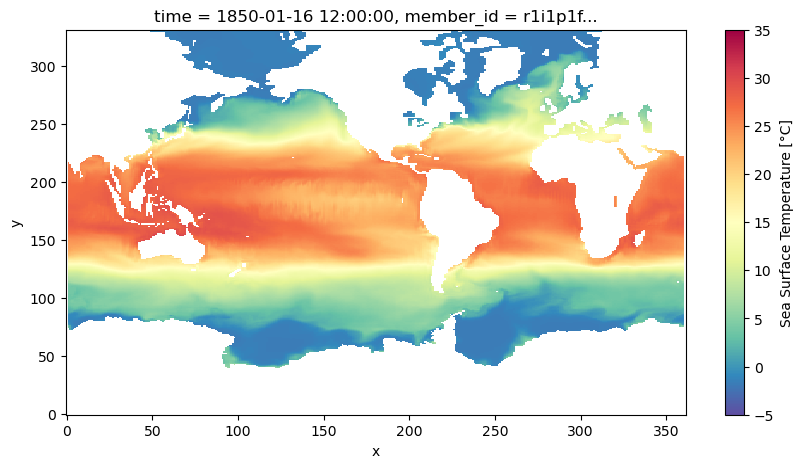

In [16]:
dt["IPSL-CM6A-LR/historical"].isel(member_id=0, dcpp_init_year=0, time=0).tos.plot(
    cmap="Spectral_r", vmin=-5, vmax=35
);

In [17]:
from dask.distributed import Client, LocalCluster

# Create a local cluster with correct arguments
cluster = LocalCluster(
    n_workers=4,              # Number of worker processes
    memory_limit='2GB'        # Per worker memory limit
)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43781/status,
Dashboard: http://127.0.0.1:43781/status,Workers: 4
Total threads: 12,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35429,Workers: 0
Dashboard: http://127.0.0.1:43781/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35947,Total threads: 3
Dashboard: http://127.0.0.1:38511/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:45311,


Ahora podemos calcular la anomalía de la temperatura superficial media global ponderada por `latitud` para cada uno de los modelos.

In [29]:
# Temperatura media global

def global_mean_sst(ds):
    """Calculate global mean SST weighted by cell area.
    
    Skips empty datasets (like root DataTree node).
    Returns a Dataset (required by map_over_datasets).
    """
    # Skip empty datasets (e.g., root DataTree node)
    if 'tos' not in ds.data_vars:
        return None
    
    # Calculate weighted mean and convert DataArray back to Dataset
    result = ds['tos'].weighted(ds.areacello.fillna(0)).mean(["x", "y"]).persist()
    return result.to_dataset()

# Map function over all non-empty datasets in the tree
timeseries = dt.map_over_datasets(global_mean_sst)
# timeseries

Podemos generar una serie de tiempo para inspeccionar los resultados. Usemos el modelo IPSl con el escenario ssp585.

In [20]:
ds_IPSL_ssp585 = timeseries["/IPSL-CM6A-LR/ssp585"].ds
ds_IPSL_ssp585 = ds_IPSL_ssp585.assign_coords(
    time=("time", ds_IPSL_ssp585.time.data.astype("datetime64[ns]"))
)
ds_IPSL_ssp585

<xarray.Dataset> Size: 12kB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1032)
Coordinates:
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) object 8B None
  * time            (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12...
Data variables:
    tos             (member_id, dcpp_init_year, time) float32 4kB dask.array<chunksize=(1, 1, 120), meta=np.ndarray>

## 4. Anomalía de la temperatura media global ponderada

De igual manera podemos remover el ciclo estacional, también llamado “climatología”, para calcular la anomalía de la temperatura superficial del Océano. 

In [21]:
# Valor medio histórico de referencia
def get_ref_value(ds):
    return ds.sel(time=slice("1950", "1980")).mean("time")


anomaly = DataTree()

for model_name, model in timeseries.children.items():
    # model-specific base period
    base_period = get_ref_value(model["historical"].ds)
    anomaly[model_name] = model - base_period  # subtree - Dataset

In [22]:
# display(anomaly)

Los datos de los modelos de cambio climático traen una estampa de `tiempo` en formato `cftime.DatetimeGregorian`. `Xarray` y `Matplotlib` generalmente trabajan con estampas de tiempo de `datetime64`. Debemos convertir estos índices usando la función `replace_time`. Luego podemos agrupar los datos por escenario usando un `diccionario` como se muestra a continuación:

In [23]:
# anomaly['/IPSL-CM6A-LR/ssp585'].time

In [24]:
def replace_time(ds):
    start_date = ds.time.data[0]
    new_time = date_range(
        f"{start_date.year}-{start_date.month:02}", freq="1MS", periods=len(ds.time)
    )
    ds_new_cal = ds.assign_coords(time=new_time, source_id=model_name)
    return ds_new_cal


experiment_dict = {
    k: [] for k in ["historical", "ssp126", "ssp370", "ssp245", "ssp585"]
}

experiment_dict

{'historical': [], 'ssp126': [], 'ssp370': [], 'ssp245': [], 'ssp585': []}

Iteramos sobre cada uno de los modelos en el objeto `datatree` donde tenemos las anomalías de la temperatura superficial del mar y las agregamos a cada una de las llaves del diccionario

In [25]:
for model_name, model in list(anomaly.children.items()):
    for experiment_name, experiment in model.children.items():
        # replace the time dimension
        ds_new_cal = replace_time(experiment.ds)
        experiment_dict[experiment_name].append(ds_new_cal.load())

Concatenamos cada escenario a lo largo de la dimension `source_id`

In [26]:
# Concatenar todos los modelos para un determinado experimento
plot_dict = {
    k: xr.concat(ds_lst, dim="source_id") for k, ds_lst in experiment_dict.items()
}
plot_dict

{'historical': <xarray.Dataset> Size: 40kB
 Dimensions:         (source_id: 3, member_id: 1, dcpp_init_year: 1, time: 1980)
 Coordinates:
   * source_id       (source_id) <U13 156B 'CMCC-ESM2' ... 'MPI-ESM1-2-LR'
   * member_id       (member_id) object 8B 'r1i1p1f1'
   * dcpp_init_year  (dcpp_init_year) object 8B None
   * time            (time) datetime64[ns] 16kB 1850-01-01 ... 2014-12-01
 Data variables:
     tos             (source_id, member_id, dcpp_init_year, time) float32 24kB ...,
 'ssp126': <xarray.Dataset> Size: 21kB
 Dimensions:         (source_id: 3, member_id: 1, dcpp_init_year: 1, time: 1032)
 Coordinates:
   * source_id       (source_id) <U13 156B 'CMCC-ESM2' ... 'MPI-ESM1-2-LR'
   * member_id       (member_id) object 8B 'r1i1p1f1'
   * dcpp_init_year  (dcpp_init_year) object 8B None
   * time            (time) datetime64[ns] 8kB 2015-01-01 ... 2100-12-01
 Data variables:
     tos             (source_id, member_id, dcpp_init_year, time) float32 12kB ...,
 'ssp370': <xar

Comprobamos que nuestras estampas de tiempo esten en el formato `datetime64`

In [27]:
plot_dict["historical"].time

<xarray.DataArray 'time' (time: 1980)> Size: 16kB
array(['1850-01-01T00:00:00.000000000', '1850-02-01T00:00:00.000000000',
       '1850-03-01T00:00:00.000000000', ..., '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000'],
      shape=(1980,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 16kB 1850-01-01 1850-02-01 ... 2014-12-01

## 5. Ensamble Multimodelo

Finalmente generamos nuestra gráfica de las proyecciones de la anomalía de temperatura superficial del mar bajo los distintos escenarios. Para esto podemos usar la función [`shaded_line_plot`](https://xarrayutils.readthedocs.io/en/latest/_modules/xarrayutils/plotting.html#shaded_line_plot) que produce un gráfico de líneas con intervalos sombreados según la extensión del `datarray` en la dimensión `source_id`. **Creamos nuestro ensamble multimodelo!!!**

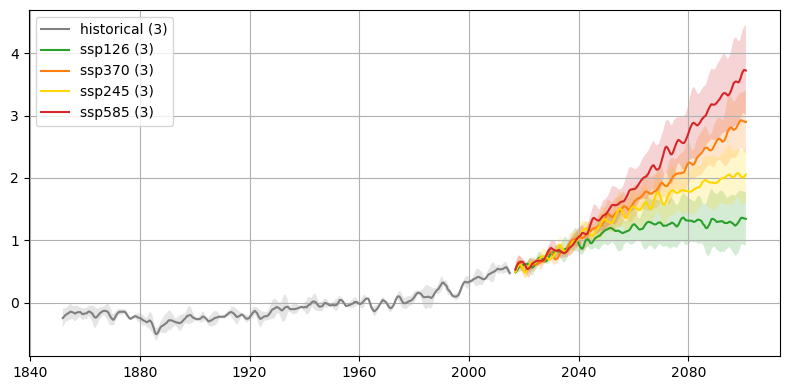

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))

color_dict = {
    "historical": "0.5",
    "ssp126": "C2",
    "ssp245": "gold",
    "ssp370": "C1",
    "ssp585": "C3",
    "observations": "C5",
}
for experiment, ds in plot_dict.items():
    color = color_dict[experiment]
    smooth = (
        ds["tos"]
        .sel(time=slice(None, "2100"))
        .isel(member_id=0)
        .rolling(time=2 * 12)
        .mean()
        .squeeze(["dcpp_init_year"])
    )
    lw = 2 if experiment == "observations" else 1.5
    shaded_line_plot(
        smooth,
        "source_id",
        ax=ax,
        spreads=[2.0],
        alphas=[0.2],
        line_kwargs=dict(
            color=color, label=f"{experiment} ({len(ds.source_id)})", lw=lw
        ),
    )
plt.legend(loc=2)
plt.grid()
plt.tight_layout()

---

## Resumen final
En este cuadernillo (notebook) revisamos temas relacionados con el acceso a la información proveniente de diferentes escenarios de Cambio Climático a partir de los conjuntos de datos disponibles en CMIP. Promediamos la temperatura superficial teniendo en cuenta el tamaño de las celdas del modelo y, reprodujimos la gráfica multimodelo de las proyecciones de cambio climático. 

## ¿Qué sigue?

Con los conocimientos sobre análisis de temperatura global con CMIP6, puedes explorar:

- **[3.3. Datos de reanálisis ERA5](3.3.ERA5.ipynb)** - Análisis de variables atmosféricas con datos de reanálisis de alta resolución
- **[3.1. ENSO](3.1.ENSO.ipynb)** - Relación entre temperatura superficial del mar y eventos El Niño/La Niña
- **Análisis regional** - Aplicar estas técnicas a regiones específicas de América Latina

### Proyecto sugerido:

Adapta este análisis para explorar:
1. Proyecciones de temperatura para Colombia o América Latina usando selecciones regionales
2. Comparación cuantitativa entre escenarios SSP2-4.5 vs SSP5-8.5
3. Análisis de incertidumbre entre diferentes modelos CMIP6 (rango de proyecciones)

## Fuentes y referencias

* ClimateMatch Academy: Computational Tools for Climate Science. (s. f.). https://comptools.climatematch.io/tutorials/intro.html
* Abernathey, R. 2023. An Introduction to Earth and Environmental Data Science. Retrieved from Earth and Environmental Data Science: https://earth-env-data-science.github.io/intro.html
* Easy IPCC Part 1: Multi-Model Datatree. Nicholas T. 2019. https://medium.com/pangeo/easy-ipcc-part-1-multi-model-datatree-469b87cf9114 
